# Algoritmos genéticos

La clase pasada quedó pendiente ver algoritmos genéticos. Consisten en metaheurísticas inspiradas en la evolución biológica. 

La idea generar es evaluar la calidad, seleccionar las **mejores** o más áptas según algún sesgo, **recombinar** pares (crossover) para producir descendencia y **mutar** levemente algunos genes. Esto reemplaza parte o toda la población.

Para el TSP se define la función **fitness** como la función objetivo de minimizar la longitud del tour: 

$$f(\pi)=\sum_{k=1}^{n}d_{\pi(k)}$$

La recombinación o crossover más utilizada es el *"Order Crossover"*: elige dos segmentos padres, copia ese segmento al hijo y rellena el resto en el orden que aparece en el otro padre. Por ejemplo:

- Padre 1: $[1 2 3 | 4 5 6 | 7 8 9]$
- Padre 2: $[9 8 7 | 6 5 4 | 3 2 1]$
- Segmento: $[4 5 6]$
- Hijo $[7 8 9 | 4 5 6 | 3 2 1]$

La mutación consistiría en una leve perturbación. Por ejemplo, hacer un **swap** entre dos posiciones, una **inserción** (sacar una ciudad e insertar otra), etc. 

El reemplazo, por lo general, se hace de forma **generacional**: todos los padres son sustituidos por hijos.

Para imponer un ejemplo, utilizaremos la librería `pycombinatorial`

In [1]:
import pandas as pd

from pyCombinatorial.algorithm import genetic_algorithm
from pyCombinatorial.utils import graphs, util

In [2]:
# Cargamos la instancia de Berlin, con solución exacta de 7544.3659
coordinates = pd.read_csv('https://github.com/Valdecy/Datasets/raw/master/Combinatorial/TSP-02-Coordinates.txt', sep = '\t')
coordinates = coordinates.values

En este caso, se tienen los siguientes parámetros:

- `population_size`: Cuantos tours hay por generación. Mientras más grande, hay más diversidad y exploración.
- `elite`: Números de mejores individuos que se preservan sin cambios en cada generación. El efecto es para evitar perder soluciones muy buenas.
- `mutation_rate`: Probabilidad de mutar de cada hijo (excepto los élite). Una mutación se definirá como un swap de dos ciudad y una búsqueda local 2-opt.
- `mutation_search`: Cuantos 2-opt se aplican dentro de cada mutación.
- `generations`: Número de iteraciones del algoritmo.

In [3]:
matriz_distancias = util.build_distance_matrix(coordinates)

parametros = {
            'population_size': 15,
            'elite': 1,
            'mutation_rate': 0.1,
            'mutation_search': 8,
            'generations': 100,
            'verbose': True
             }

route, distance = genetic_algorithm(matriz_distancias, **parametros)

Generation =  0 Distance =  27477.0
Generation =  1 Distance =  18876.29
Generation =  2 Distance =  18876.29
Generation =  3 Distance =  13892.44
Generation =  4 Distance =  11224.51
Generation =  5 Distance =  11066.25
Generation =  6 Distance =  11066.25
Generation =  7 Distance =  11066.25
Generation =  8 Distance =  11066.25
Generation =  9 Distance =  9977.15
Generation =  10 Distance =  9905.31
Generation =  11 Distance =  9905.31
Generation =  12 Distance =  9182.23
Generation =  13 Distance =  9182.23
Generation =  14 Distance =  9182.23
Generation =  15 Distance =  9182.23
Generation =  16 Distance =  9178.87
Generation =  17 Distance =  9138.25
Generation =  18 Distance =  9138.25
Generation =  19 Distance =  9138.25
Generation =  20 Distance =  8940.56
Generation =  21 Distance =  8940.56
Generation =  22 Distance =  8648.06
Generation =  23 Distance =  8648.06
Generation =  24 Distance =  8576.41
Generation =  25 Distance =  8576.41
Generation =  26 Distance =  8576.41
Gen

Como se puede ver, el rendimiento del algoritmo genético es **muy bueno** en el TSP, incluso llegando al óptimo exacto del problema.

# Vehicle Route Problem

El problema del ruteo de vehículo consiste en un problema que, para $m$ autos, se pide satisfacer la demanda de $v$ clientes, donde cada auto $n$ posee una capacidad $Q_n$. Sólamente un auto puede pasar por un cliente $v$ y todos parten desde el mismo punto $x_0$ (la bodega)

Para trabajar con el problema VRP existen diversas librerías de Python. En nuestro caso, utilizaremos la librería `PyVRP` que es la librería pionera para este tipo de problemas.

In [4]:
!pip3 install pyvrp vrplib

Importamos las librerías que utilizaremos

In [5]:
import matplotlib.pyplot as plt
from tabulate import tabulate
from vrplib import read_solution

from pyvrp import read, solve
from pyvrp.plotting import (
    plot_coordinates,
    plot_instance,
    plot_result,
    plot_route_schedule,
)
from pyvrp.stop import MaxIterations, MaxRuntime

In [6]:
INSTANCE = read("data/X-n439-k37.vrp", round_func="round")
BKS = read_solution("data/X-n439-k37.sol")

Veamos como se ve la instancia

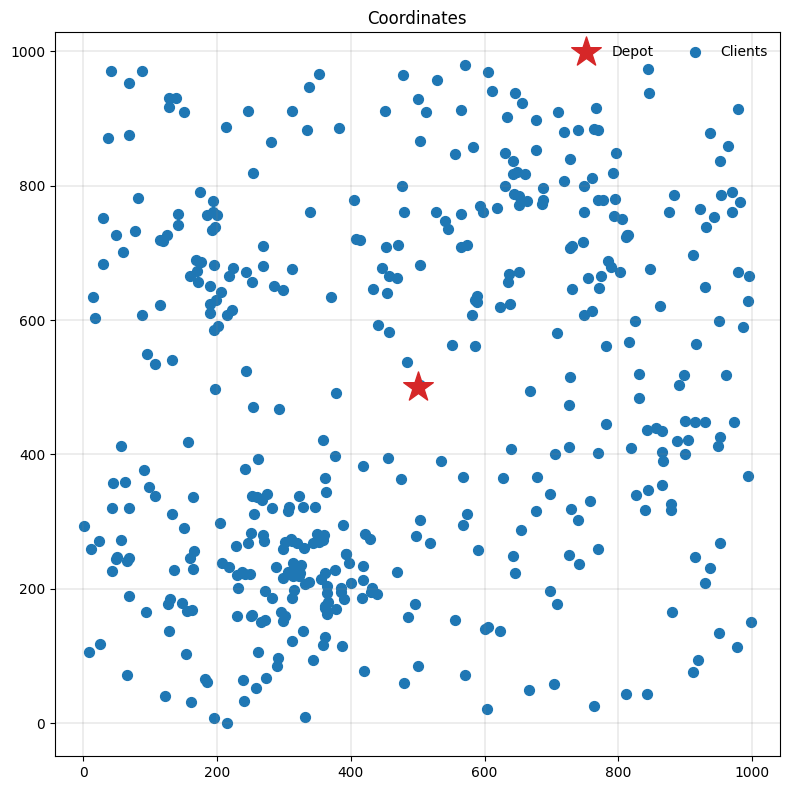

In [7]:
_, ax = plt.subplots(figsize=(8, 8))
plot_coordinates(INSTANCE, ax=ax)
plt.tight_layout()

Primero, utilizaremos el método que viene por defecto en la librería (`solve`). Luego, veremos como aplicar nuestras propias heurísticas. 

In [8]:
result = solve(INSTANCE, stop=MaxIterations(2000), seed=42, display=True)


PyVRP v0.11.3

Solving an instance with:
    1 depot
    438 clients
    438 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      7s |  61    42183    37039 |  63    37423    36982
H    1000     12s |  55    42377    36874 |  43    37401    36985
H    1500     18s |  47    43093    36756 |  37    37141    36931
H    2000     24s |  42    44094    36648 |  44    34007    32194

Search terminated in 23.63s after 2000 iterations.
Best-found solution has cost 36648.

Solution results
    # routes: 37
     # trips: 37
   # clients: 438
   objective: 36648
    distance: 36648
    duration: 36648
# iterations: 2000
    run-time: 23.63 seconds



El cuadro que estamos viendo, en realidad, es la heurística de **Hybrid Genetic Search** **(HGS)**.

La idea general es que se inicia de una población inicial, donde se generan varias soluciones iniciales (pueden ser aleatorias o heurísticas rápidas). 

En cada iteración se eligen **dos** padres de la población. Los dos padres se combinan en un **hijo**, heredando subestructuras de rutas en ambos. El hijo pasa por una **búsqueda local** y se corrigen ineficiencias y errores de factibilidad. Así, el hijo no sólamente se mezcla en genes, si no que también se optimiza antes de competir en la población. 

Al añadir el hijo a la población, se establece el criterio de, si la población crece demasiado, aplicar un **survivor selection**: eliminar las soluciones con peor función objetivo.

In [9]:
gap = 100 * (result.cost() - BKS["cost"]) / BKS["cost"]
print(f"Encontramos una solución con costo: {result.cost()}.")
print(f"Esto es un {gap:.1f}% peor que la mejor solución,", end=" ")
print(f"que es {BKS['cost']}.")

Encontramos una solución con costo: 36648.
Esto es un 0.7% peor que la mejor solución, que es 36391.


## Visualizando la solución

La gracia de la librería es que también ofrece muchas formas de visualizar la solución. En específico, nos devuelve un objeto `Result`:

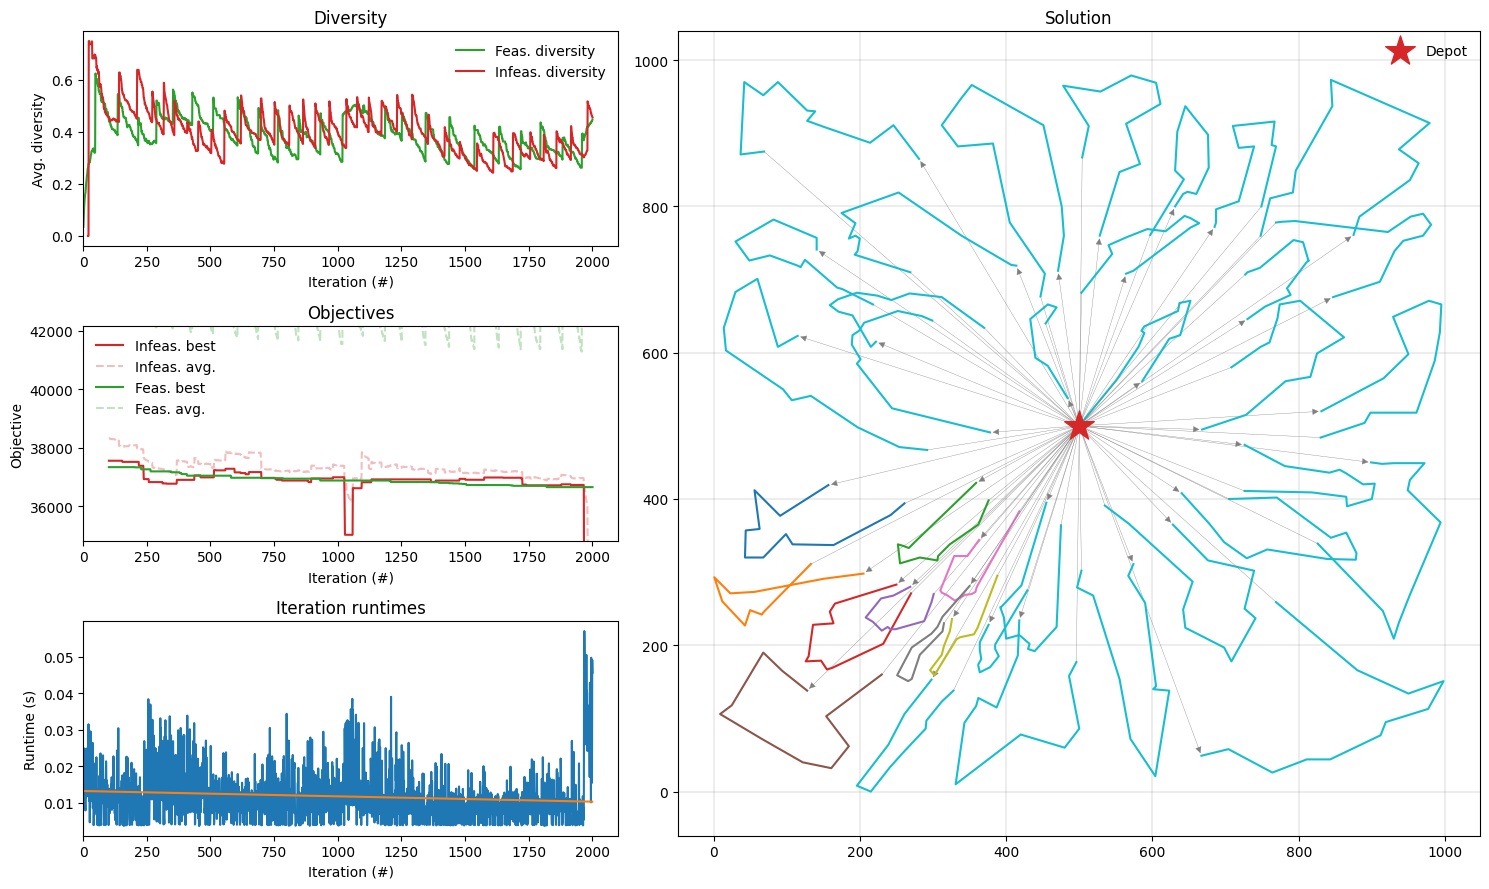

In [10]:
fig = plt.figure(figsize=(15, 9))
plot_result(result, INSTANCE, fig)
fig.tight_layout()


Además, es posible ver sus estadísticas 

## Problema con tiempos de espera

Existe una variación del problema donde cada nodo debe ser visitado en un margen de tiempo. Para esto, utilizaremos la instancia `PR21B`

In [11]:
INSTANCE = read("data/PR17.vrp", round_func="dimacs")
BKS = read_solution("data/PR17.sol")


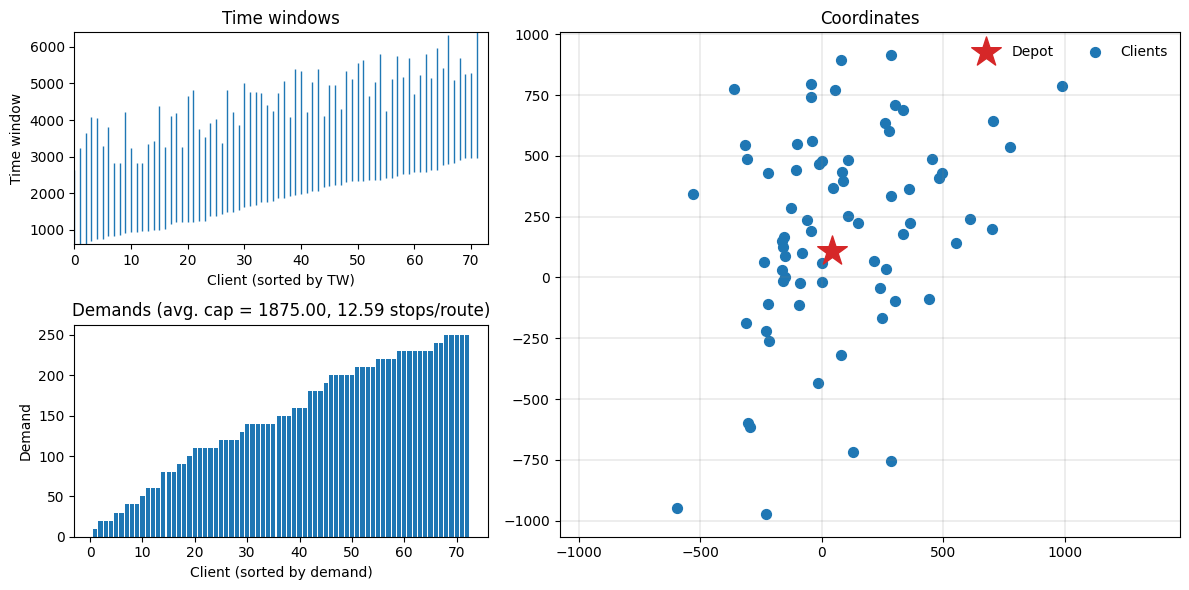

In [12]:
fig = plt.figure(figsize=(12, 6))
plot_instance(INSTANCE, fig)

Es posible resolver la instancia de la misma forma que lo hicimos antes

In [13]:
result = solve(INSTANCE, stop=MaxIterations(1000), seed=42, display=True)


PyVRP v0.11.3

Solving an instance with:
    1 depot
    72 clients
    12 vehicles (6 vehicle types)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      2s |  53    19124    18466 |  61 7778999725046657    18231
H    1000      3s |  38    18996    18427 |  28 7660622966175897    18074

Search terminated in 3.20s after 1000 iterations.
Best-found solution has cost 18427.

Solution results
    # routes: 8
     # trips: 8
   # clients: 72
   objective: 18427
    distance: 18427
    duration: 26487
# iterations: 1000
    run-time: 3.20 seconds



De forma similar, podemos ver como se solucionó la instancia

In [14]:
costo = result.cost() / 10
gap = 100 * (costo - BKS["cost"]) / BKS["cost"]
print(f"Encontramos una solución con costo: {costo}.")
print(f"Esto tiene un gap {gap:.1f}% peor que la solución óptima,", end=" ")
print(f"que es {BKS['cost']}.")

Encontramos una solución con costo: 1842.7.
Esto tiene un gap 0.3% peor que la solución óptima, que es 1837.946.


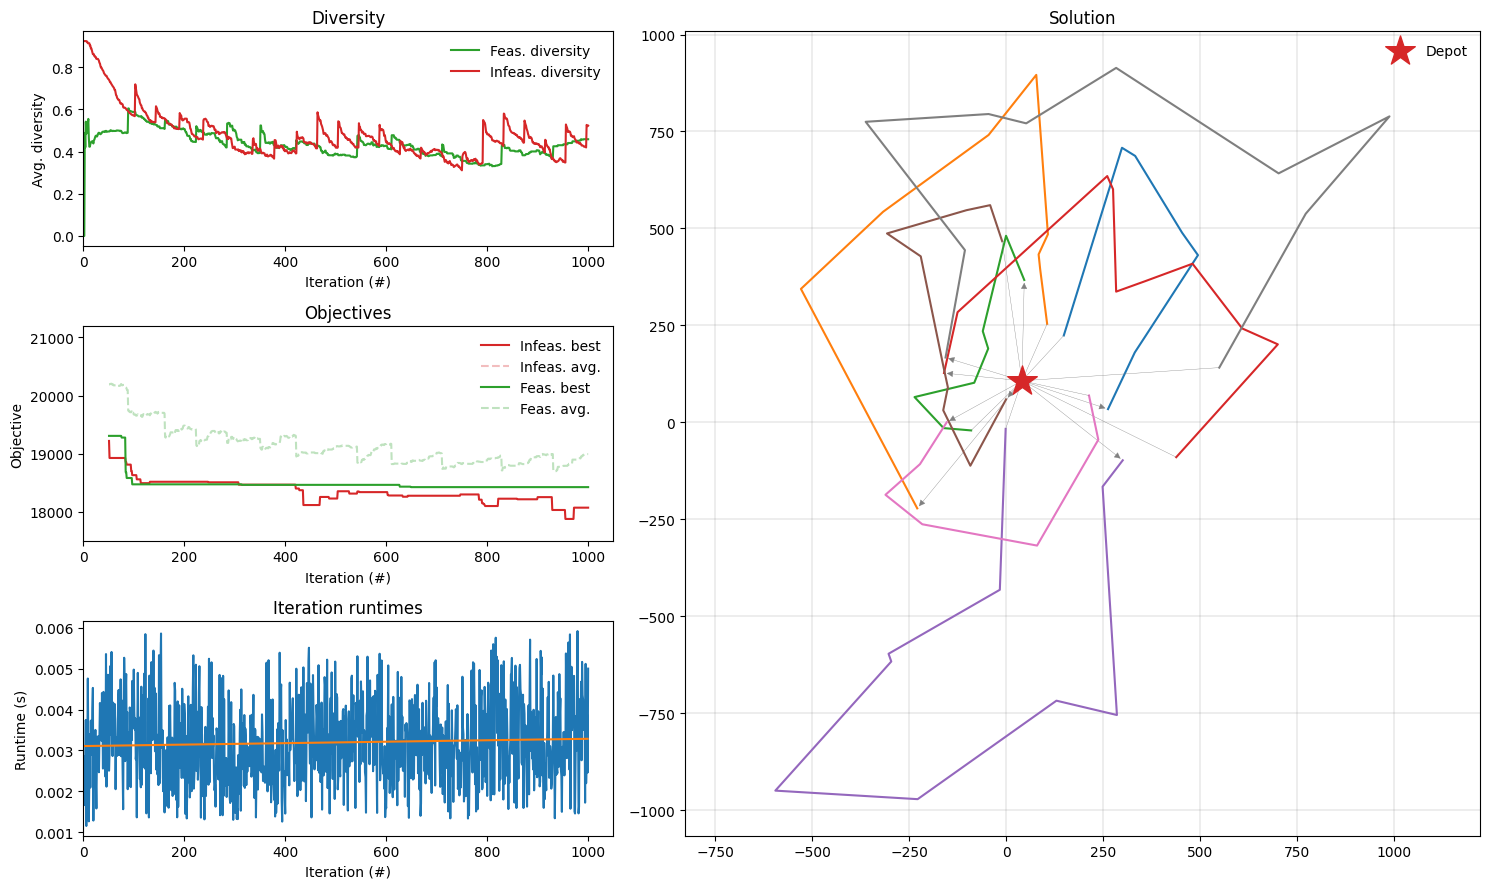

In [15]:
fig = plt.figure(figsize=(15, 9))
plot_result(result, INSTANCE, fig)
fig.tight_layout()

También es posible inspeccionar el rendimiento en una tabla

In [16]:
solution = result.best
routes = solution.routes()

data = [
    {
        "num_stops": len(route),
        "distance": route.distance(),
        "service_duration": route.service_duration(),
        "delivery": route.delivery(),
    }
    for route in routes
]

tabulate(data, headers="keys", tablefmt="html")

num_stops,distance,service_duration,delivery
8,1700,1040,[1230]
9,2700,900,[1290]
8,1299,1180,[1020]
10,2541,1010,[1390]
10,3315,930,[1610]
10,1663,950,[1630]
7,1501,840,[1140]
10,3708,1210,[1410]


También es posible inspeccionar las rutas con `plot_route_schedule`

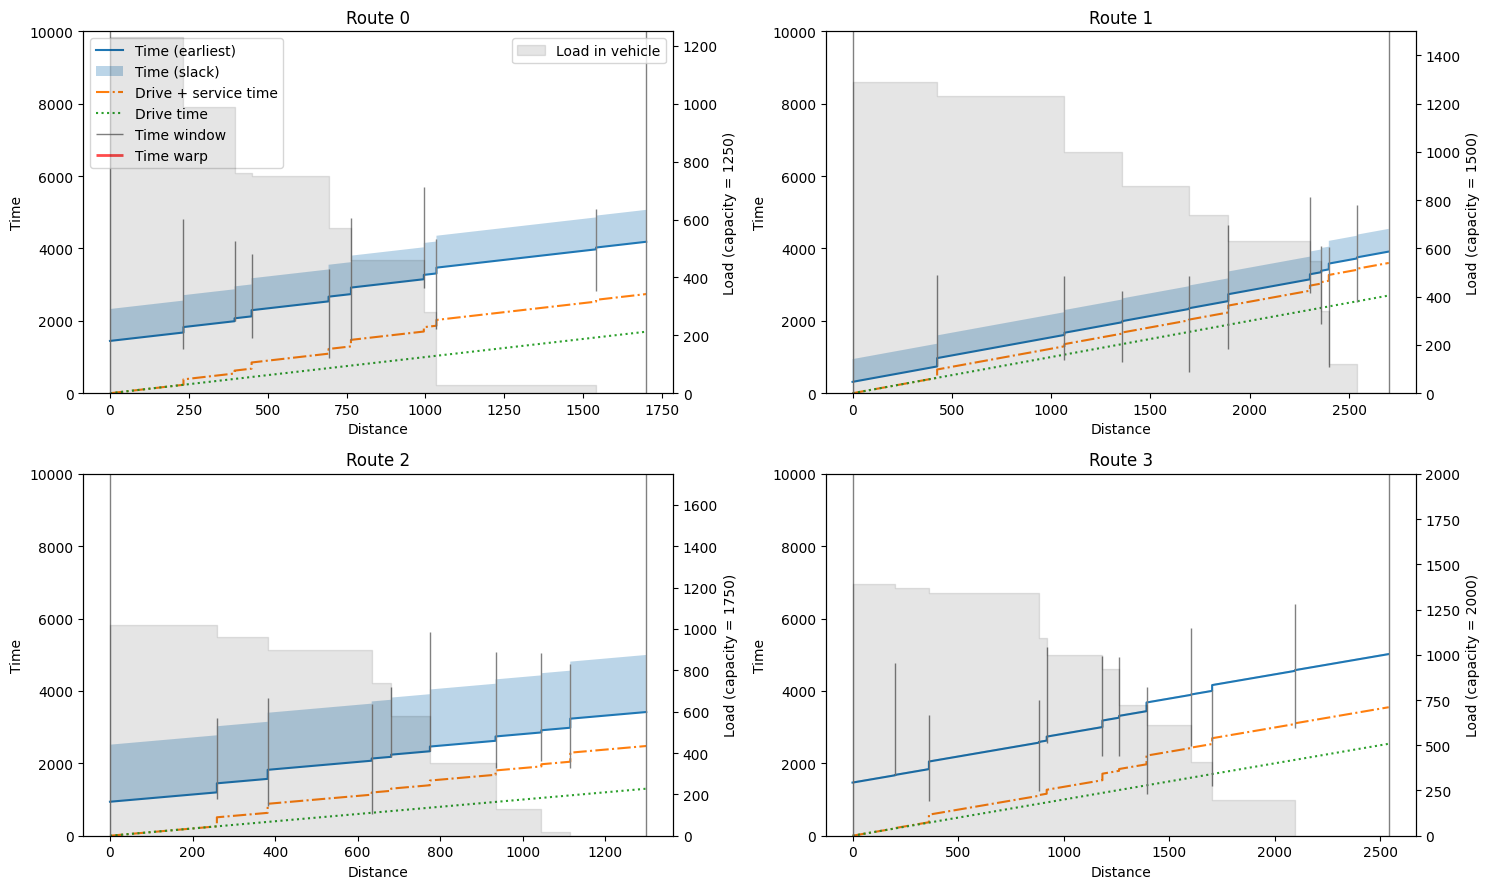

In [17]:
fig, axarr = plt.subplots(2, 2, figsize=(15, 9))
for idx, (ax, route) in enumerate(zip(axarr.flatten(), routes)):
    plot_route_schedule(
        INSTANCE,
        route,
        title=f"Route {idx}",
        ax=ax,
        legend=idx == 0,
    )

fig.tight_layout()

## Entendiendo el algoritmo por detrás

Como explicamos antes, el algoritmo que funciona por detrás de la librería es el **HGS**, explicado en los papers de Vidal et al (2013) y Vidal (2022).


## Método de búsqueda

Como explicamos anteriormente, el algoritmo genético implementa un método de búsqueda al hacer la mutación. Es posible customizar el método de búsqueda con distintas heurísticas de nuestro gusto. 

La forma en que funciona en el paquete es la siguiente: 

- Cada nodo tiene un "operador". Tal operador es la heurística de búsqueda local que se aplicará en tal nodo.
- Idém para las aristas

Como ejemplo, utilicemos el `LocalSearch`

In [18]:
from pyvrp.search import (
    NODE_OPERATORS,
    ROUTE_OPERATORS,
    LocalSearch,
    compute_neighbours,
)
from pyvrp import RandomNumberGenerator

# INSTANCE = read("data/PR12B.vrp", "dimacs")

rng = RandomNumberGenerator(seed=42)
neighbours = compute_neighbours(INSTANCE)
ls = LocalSearch(INSTANCE, rng, neighbours)

for node_op in NODE_OPERATORS:
    ls.add_node_operator(node_op(INSTANCE))

for route_op in ROUTE_OPERATORS:
    ls.add_route_operator(route_op(INSTANCE))

Con esto, tenemos un método de `LocalSearch`.

Ahora, importemos `Solution`y `CostEvaluator`. `Solution` va a ser el objeto que nos dará la solución dado las operaciones que definimos en nuestros nodos. `CostEvaluator` va a ser la función de costos que tenemos, que se le puede poner penalizaciones por ser infactible

In [19]:
from pyvrp import CostEvaluator, Solution

cost_evaluator = CostEvaluator(
    load_penalties=[0], # Penalización por exceso de capacidad
    tw_penalty=0, # Penalización por violar ventanas de tiempo, 0 para formarlo sin ventanas de tiempo
    dist_penalty=0, # Violación por distancia recorrida
)
sol = Solution.make_random(INSTANCE, rng)

Notemos como mejora el costo al utilizar una búsqueda local.

In [20]:
print(cost_evaluator.penalised_cost(sol))


220676381741178249


In [21]:
nueva_solucion = ls.search(sol, cost_evaluator)

print(cost_evaluator.penalised_cost(nueva_solucion))

17748


Se llega a una mejora mucho mejor, sin embargo, lo más probable es que no sea factible

In [22]:
nueva_solucion.is_feasible()


False

Para poder garantizar factibilidad, es posible castigar más las infactibilidades

In [23]:
cost_evaluator = CostEvaluator(
    load_penalties=[20], # Penalización por exceso de capacidad
    tw_penalty=20, # Penalización por violar ventanas de tiempo, 0 para formarlo sin ventanas de tiempo
    dist_penalty=0, # Violación por distancia recorrida
)
sol2 = Solution.make_random(INSTANCE, rng)

In [24]:
nueva_solucion2 = ls.search(sol2, cost_evaluator)

print(cost_evaluator.penalised_cost(nueva_solucion2))
print(nueva_solucion2.is_feasible())

19937
True


Así, es como se balancea entre soluciones factibles y no factibles, garantizando un mejor `crossover` en el algoritmo genético

Por lo tanto, el objeto que se encargará de manejar los términos de penalización será `PenaltyManager`. A este se le podrá pedir que nos de un `cost_evaluator` de la forma que acabamos de ver

In [25]:

from pyvrp import PenaltyManager

pen_manager = PenaltyManager.init_from(INSTANCE)
cost_evaluator = pen_manager.cost_evaluator()

## Manejando la población

La población corresponde a la cantidad de soluciones que van "sobreviviendo". De cierta forma, también, nos va garantizando variedad entre soluciones.

In [26]:
from pyvrp import Population
from pyvrp.diversity import broken_pairs_distance

pop = Population(broken_pairs_distance)

Para poder calcular que tan dísimil son las soluciones entre poblaciones, existen varias formas. En este caso, se utilizará el índice de `broken_pairs_distance`

Las poblaciones suelen partir vacias, la idea es partir llenándolas, usualmente, con rutas aleatorias como semilla inicial.

## El algoritmo genético 

Como fue dicho anteriormente, nos generamos nuestra semilla de soluciones iniciales, de forma aleatoria

In [27]:
init_sols = [Solution.make_random(INSTANCE, rng) for _ in range(25)]


Además, importaremos nuestro método de crossover. En este caso, usaremos el método `SREX` que corresponde al "selective route exchange". 

In [28]:
from pyvrp import GeneticAlgorithm
from pyvrp.crossover import selective_route_exchange as srex

algo = GeneticAlgorithm(
    INSTANCE,
    pen_manager,
    rng,
    pop,
    ls,
    srex,
    init_sols,
)

Ahora, el algoritmo lo podemos correr bajo un criterio de parada, tanto por iteraciones o tiempo. En este caso, lo correremos por 10 segundos.

In [29]:
from pyvrp.stop import MaxRuntime

tiempo = algo.run(stop=MaxRuntime(10))

In [30]:
print(tiempo)

Solution results
    # routes: 8
     # trips: 8
   # clients: 72
   objective: 18339
    distance: 18339
    duration: 26399
# iterations: 3162
    run-time: 10.00 seconds

Routes
------
Route #1: 39 4 13 44 41 53 60 20
Route #2: 58 34 33 66 42 40 7 36
Route #3: 50 51 29 70 63 67 61
Route #4: 68 24 43 6 2 37 35 17 59 14 15
Route #5: 30 22 10 54 11 25 28 9 45 8 26
Route #6: 71 72 16 27 23 46 3 65 64
Route #7: 62 48 47 38 12 56 49 69
Route #8: 31 57 52 19 21 32 18 1 55 5



# Problema de P-mediana

Se tiene un conjunto de nodos de demanda, por ejemplo, ciudades, clientes, supermercados, etc. Además, otro conjunto de posibles **sitios de instalación**. Una matriz de distancias o costos $d_{ij}$ entre nodo de demanda $i$ y sitio $j$. Un número fijo $p$ de instalaciones a ubicar. 

El objetivo es **elegir $p$ instalaciones de modo que se minimice la suma de las distancias de asignar cada nodo de demanda a su instalación más cercana.** 

Su formulación matemática, con $y_j$ siendo la variable binaria para ver si abre la instalación en el sitio $j$ y $x_{ij}=1$ si el cliente $i$ se le asigna la instalación $j$:

$$\min\sum_{i\in D}\sum_{j\in F}d_{ij}x_{ij}$$ 

Sujeto que

- Cada demanda se le asigna una instalación: 

$$\sum_{j\in F}x_{ij}=1\;\;\;\forall i\in D$$

- Sólo puede asignarse a instalaciones abiertas:

$$x_{ij}\leq y_j\;\;\;\forall i\in D,\;j\in F$$

- Se deben abrir, exactamente $p$ instalaciones:

$$\sum_{j\in F}y_j=p$$ 

Lamentablemente, no existe una librería bien establecida que implemente soluciones para el problema de la p-mediana. A continuación, esbozamos una clase para poder simular instancias y resolver el problema mediante el algoritmo de **loc-alloc**

In [34]:
import math
import random
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict

import numpy as np
import matplotlib.pyplot as plt


In [39]:


def _pairwise_dist(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    """Matriz de distancias euclidianas entre A (n,2) y B (m,2)."""
    A2 = np.sum(A * A, axis=1, keepdims=True)      # (n,1)
    B2 = np.sum(B * B, axis=1, keepdims=True).T    # (1,m)
    D2 = A2 + B2 - 2 * (A @ B.T)
    D2 = np.maximum(D2, 0.0)
    return np.sqrt(D2)

@dataclass
class FacilityPMedianSim:
    n_clients: int
    m_candidates: int
    p: int
    seed: int = 0

    # se llenan tras generate()
    clients_xy: Optional[np.ndarray] = None   # (n,2)
    fac_xy: Optional[np.ndarray] = None       # (m,2)
    demands: Optional[np.ndarray] = None      # (n,)

    def generate(self,
                 client_center=(0.0, 0.0),
                 client_scale=1.0,
                 fac_center=(0.2, 0.2),
                 fac_scale=1.0,
                 demand_low=1,
                 demand_high=5) -> None:
        """
        Genera clientes, candidatos y demandas.
        """
        rng = np.random.default_rng(self.seed)
        self.clients_xy = rng.normal(loc=client_center, scale=client_scale, size=(self.n_clients, 2))
        self.fac_xy = rng.normal(loc=fac_center, scale=fac_scale, size=(self.m_candidates, 2))
        self.demands = rng.integers(demand_low, demand_high + 1, size=self.n_clients).astype(float)

    def plot_instance(self, title="Instancia p-mediana") -> None:
        assert self.clients_xy is not None and self.fac_xy is not None
        plt.figure(figsize=(7, 6))
        plt.scatter(self.clients_xy[:, 0], self.clients_xy[:, 1], s=20, alpha=0.7, label="Clientes")
        plt.scatter(self.fac_xy[:, 0], self.fac_xy[:, 1], marker="x", s=70, c="tab:red", label="Candidatos")
        plt.title(title)
        plt.axis("equal"); plt.grid(True, alpha=0.25); plt.legend(); plt.show()

    def plot_solution(self,
                      open_idx: np.ndarray,
                      assignment: np.ndarray,
                      title: str = "Solución loc-alloc") -> None:
        """Dibuja clientes coloreados por centro y los candidatos abiertos/cerrados."""
        assert self.clients_xy is not None and self.fac_xy is not None
        p = len(open_idx)
        cmap = plt.get_cmap("tab10", p)

        plt.figure(figsize=(7, 6))
        # clientes por cluster (índice local en [0..p-1])
        for k in range(p):
            mask = (assignment == k)
            plt.scatter(self.clients_xy[mask, 0], self.clients_xy[mask, 1], s=25, alpha=0.8, c=[cmap(k)], label=f"Cluster {k}")

        closed = np.setdiff1d(np.arange(self.fac_xy.shape[0]), open_idx, assume_unique=True)
        plt.scatter(self.fac_xy[closed, 0], self.fac_xy[closed, 1], marker="x", s=70, c="gray", alpha=0.6, label="Candidatos cerrados")
        plt.scatter(self.fac_xy[open_idx, 0], self.fac_xy[open_idx, 1], marker="^", s=120,
                    edgecolor="k", linewidths=1.2, c=[cmap(i) for i in range(p)], label="Instalaciones abiertas")

        plt.title(title); plt.axis("equal"); plt.grid(True, alpha=0.25); plt.legend(); plt.show()
        
"""
Función para hacer seeding
"""
def _kpp_init(clients_xy: np.ndarray,
              fac_xy: np.ndarray,
              p: int,
              rng: np.random.Generator) -> np.ndarray:
    """Seeding k-means++ sobre candidatos (índices únicos)."""
    m = fac_xy.shape[0]
    centers = [int(rng.integers(m))]
    D = _pairwise_dist(fac_xy, fac_xy[centers])[:, 0]
    while len(centers) < p:
        probs = D**2
        if probs.sum() <= 0:
            remaining = list(set(range(m)) - set(centers))
            need = p - len(centers)
            centers += list(rng.choice(remaining, size=need, replace=False))
            break
        probs /= probs.sum()
        nxt = int(rng.choice(m, p=probs))
        centers.append(nxt)
        D = np.minimum(D, _pairwise_dist(fac_xy, fac_xy[[nxt]])[:, 0])
    return np.array(sorted(set(centers)))[:p]


## Algoritmo Loc-Alloc

Unos de los algoritmos más eficiente en tiempo. 

Es un problema de dos fases: 

- **Alloc** (asignación): Con un conjunto actual de $p$ instalaciones abiertas, asigna cada cliente a su instalación **abierta más cercana**. 

- **Loc** (ubicación): Mejora la ubicación de las $p$ instalaciones. Esto se puede realizar mediante **swaps** utilizando heurísticas. La más común es el swap greedy, donde conviene hacer el intercambio inmediato si vemos una localización que mejora el costo.

Así, nos definimos la función auxiliar, que asigna cada cliente al centro más cercano

In [42]:

def _assign_and_cost(clients_xy: np.ndarray,
                     fac_xy: np.ndarray,
                     demands: np.ndarray,
                     open_idx: np.ndarray) -> Tuple[np.ndarray, float]:
    """Asigna cada cliente al centro más cercano y retorna (assignment_local, cost)."""
    D = _pairwise_dist(clients_xy, fac_xy[open_idx])  # (Función que retorna la matriz de distancia)
    assign = np.argmin(D, axis=1) # A partir de la matriz de distancia, asignamos aquel que minimiza la distancia
    cost = float((demands * D[np.arange(len(demands)), assign]).sum()) 
    return assign, cost

Por lo tanto, nos definimos la función principal

In [ ]:
def loc_alloc(clients_xy: np.ndarray,
              fac_xy: np.ndarray,
              p: int,
              demands: Optional[np.ndarray] = None,
              max_iter: int = 50,
              seed: int = 0,
              verbose: bool = True) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Heurística loc-alloc (p-median discreto con swaps 1↔1):
      1) Inicializa p centros con k++.
      2) Alterna Asignación (nearest) y Loc (swaps que mejoran el costo).
      3) Termina cuando no hay mejora.
    Retorna: (open_idx, assignment_local, cost_total).
    """

    # Número de clientes (n) y candidatos (m)
    n = clients_xy.shape[0]
    m = fac_xy.shape[0]

    # Verificación de que p sea válido (no puedes abrir más que m)
    assert 1 <= p <= m

    # Generador de aleatoriedad
    rng = np.random.default_rng(seed)

    # Si no hay demandas, cada cliente vale 1
    demands = np.ones(n) if demands is None else demands.astype(float)

    # Inicialización con k-means++ (elige p facilidades iniciales "inteligentes"), asuman que es random si no
    open_idx = _kpp_init(clients_xy, fac_xy, p, rng)

    # Asignar clientes a esas facilidades y calcular el costo inicial
    assignment, best_cost = _assign_and_cost(clients_xy, fac_xy, demands, open_idx)

    if verbose:
        print(f"[init] costo={best_cost:.4f}, open={open_idx.tolist()}")

    # Bucle principal:
    for it in range(1, max_iter + 1):
        improved = False      # bandera para ver si mejoramos
        best_delta = 0.0      # mejor mejora encontrada en esta iteración
        best_swap = None      # guardamos el swap ganador

        # --- Pre-cálculo: nearest y second-nearest facility de cada cliente ---
        D_open = _pairwise_dist(clients_xy, fac_xy[open_idx])  # matriz dist (n, p)
        nearest = np.argmin(D_open, axis=1)                    # índice local del centro más cercano
        dist_near = D_open[np.arange(n), nearest]              # distancia al más cercano

        # Para calcular el "segundo más cercano":
        D_open[np.arange(n), nearest] = np.inf                 # ocultamos el nearest
        second = np.argmin(D_open, axis=1)                     # índice del segundo más cercano
        dist_second = D_open[np.arange(n), second]             # distancia al segundo más cercano

        # restauramos las distancias originales
        D_open[np.arange(n), nearest] = dist_near

        # Candidatos cerrados (los que NO están en open_idx)
        closed = np.setdiff1d(np.arange(m), open_idx, assume_unique=True)

        # --- Intentamos todos los swaps 1↔1 ---
        # Quitamos un centro f (abierto) y lo reemplazamos por uno g (cerrado)
        for pos_f, f in enumerate(open_idx):
            for g in closed:
                # Distancia de cada cliente al candidato g
                Dg = _pairwise_dist(clients_xy, fac_xy[[g]])[:, 0]   # (n,)

                # Si el nearest actual del cliente era f, debemos usar el segundo o g
                use_second = (nearest == pos_f)

                # Nueva distancia = min(dist a g, dist a nearest/second)
                new_dist = np.where(use_second,
                                    np.minimum(dist_second, Dg),   # cliente dependía de f
                                    np.minimum(dist_near, Dg))     # cliente no dependía de f

                # Nuevo costo total (demanda * distancia)
                new_cost = float((demands * new_dist).sum())

                # Mejora obtenida
                delta = best_cost - new_cost

                # Si es la mejor mejora hasta ahora, guardamos el swap
                if delta > best_delta:
                    best_delta = delta
                    best_swap = (pos_f, f, g)

        # Si no encontramos mejora, terminamos
        if best_swap is None or best_delta <= 1e-9:
            if verbose:
                print(f"[it {it}] sin mejora. paro.")
            break

        # Aplicamos el mejor swap encontrado
        pos_f, f, g = best_swap
        open_idx = open_idx.copy()
        open_idx[pos_f] = g                   # reemplazar f por g
        open_idx = np.array(sorted(open_idx)) # mantener ordenado

        # Re-asignamos clientes y actualizamos el costo
        assignment, best_cost = _assign_and_cost(clients_xy, fac_xy, demands, open_idx)
        improved = True

        if verbose:
            print(f"[it {it}] Δ={best_delta:.4f} -> costo={best_cost:.4f} | swap {f}→{g} | open={open_idx.tolist()}")

    # Al final retornamos: (facilidades abiertas, asignación de clientes, costo)
    return open_idx, assignment, best_cost

Por lo tanto, podemos crear una instancia y plotearla

In [ ]:
sim = FacilityPMedianSim(n_clients=150, m_candidates=30, p=5, seed=42)
sim.generate(client_center=(0, 0), client_scale=1.0,
             fac_center=(0.3, 0.2), fac_scale=1.2,
             demand_low=1, demand_high=5)
sim.plot_instance("Instancia p-mediana (simulada)")

Y su solución, con **loc-alloc**, llegaría a ser la siguiente

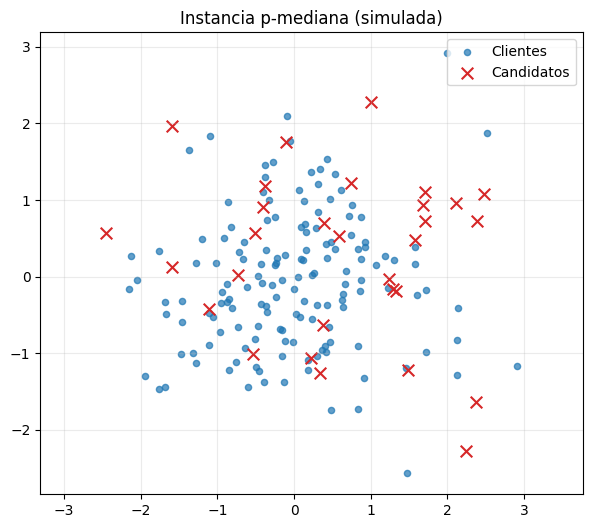

[init] costo=483.8384, open=[2, 4, 12, 22, 25]
[it 1] Δ=122.7202 -> costo=361.1181 | swap 4→29 | open=[2, 12, 22, 25, 29]
[it 2] Δ=36.2632 -> costo=324.8549 | swap 12→28 | open=[2, 22, 25, 28, 29]
[it 3] Δ=23.5371 -> costo=301.3179 | swap 22→14 | open=[2, 14, 25, 28, 29]
[it 4] Δ=14.4581 -> costo=286.8597 | swap 25→26 | open=[2, 14, 26, 28, 29]
[it 5] Δ=5.1949 -> costo=281.6648 | swap 29→9 | open=[2, 9, 14, 26, 28]
[it 6] sin mejora. paro.
Costo final: 281.665 | Abiertos: [2, 9, 14, 26, 28]


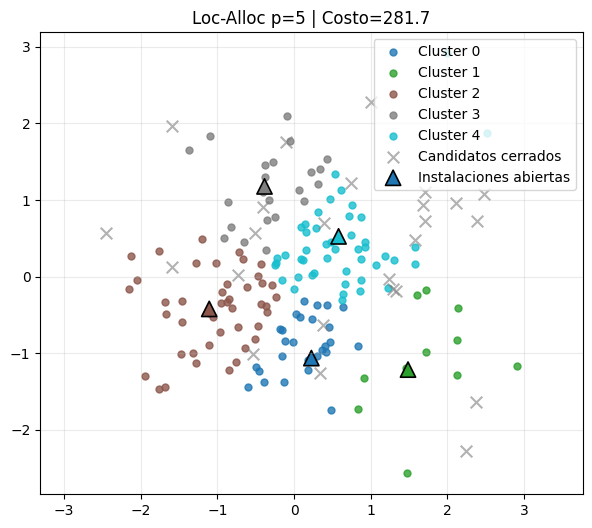

In [41]:
open_idx, assignment, cost = loc_alloc(sim.clients_xy, sim.fac_xy, sim.p, sim.demands,
                                       max_iter=60, seed=42, verbose=True)
print(f"Costo final: {cost:.3f} | Abiertos: {open_idx.tolist()}")

sim.plot_solution(open_idx, assignment, title=f"Loc-Alloc p={sim.p} | Costo={cost:.1f}")